In [1]:
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("季节数据.csv")   
#读取数据
df.head()#查看数据前5行

,date0,date1,sum
0,20200101,2020/1/1,42889
1,20200102,2020/1/2,58865
2,20200103,2020/1/3,57255
3,20200104,2020/1/4,64181
4,20200105,2020/1/5,64806


In [3]:
#获取values列名数据
data=df['sum']
date=df['date1'] #获取date列日期数据

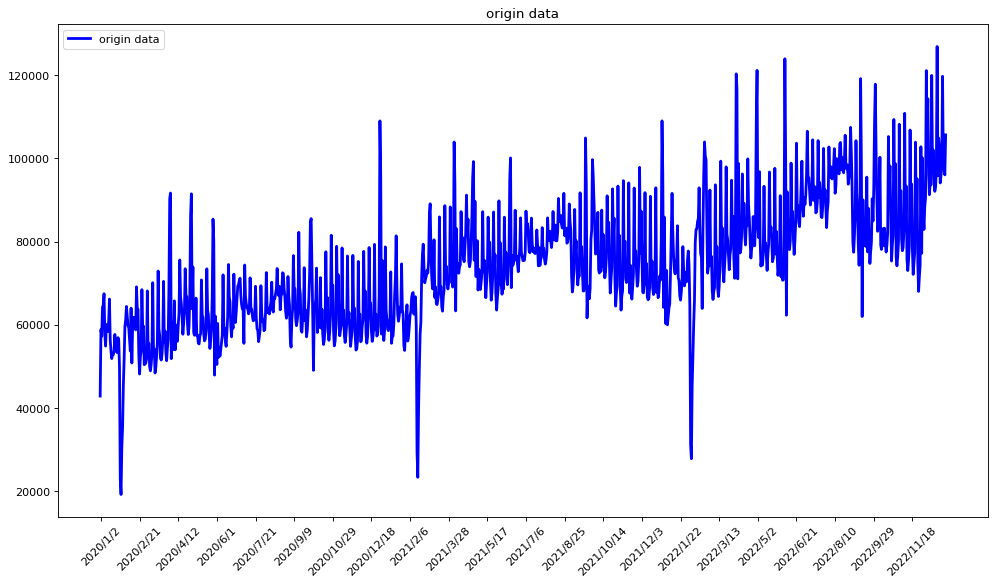

In [4]:
#显示原数据
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date,data, label="origin data", color='b',lw=2.5)  #若不需要日期或者数据没有日期可改成plt.plot(data, label=" ", color='b',lw=2.5)
plt.title("origin data")
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

In [5]:
#定义稳定性检验函数
def adf_val(ts, ts_title):
    '''
    ts: 时间序列数据，Series类型
    ts_title: 时间序列图的标题名称，字符串
    '''
    # 稳定性（ADF）检验
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)

    name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,critical_values, icbest]
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,
    # 返回adf值、adf的p值、三种状态的检验值

In [6]:
#白噪声检验也称为纯随机性检验，当数据是纯随机数据时，再对数据进行分析就没有任何意义了，所以拿到数据后最好对数据进行一个纯随机性检验。
def acorr_val(ts):
    '''
    # 白噪声（随机性）检验
    ts: 时间序列数据，Series类型
    返回白噪声检验的P值
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1)  # 白噪声检验结果
    return lbvalue, pvalue



def tsplot(y, lags=None, figsize=(15, 8)):
    fig = figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title('origin  data')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    #自相关（Autocorrelation）： 对一个时间序列，现在值与其过去值的相关性。如果相关性为正，则说明现有趋势将继续保持。
    plot_acf(y, lags=lags, ax=acf_ax)
    #可以度量现在值与过去值更纯正的相关性
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()

    fig.tight_layout()
    fig.savefig('result/ACF_PACF.png')#图片保存路径
    fig.show()

    return ts_ax, acf_ax, pacf_ax

In [7]:
#获取values列名的数据，并转为float32类型数据
ts_data = data.astype('float32')

In [8]:
#平稳性检验
adf1, pvalue1, critical_values1 = adf_val(ts_data, 'raw time series') #对原数据进行平稳性判断
print('adf',adf1)
print('pvalue1',pvalue1)
print('critical_values',critical_values1)
#结果显示，adf结果为-2.2394..， 不小于critical_values的三个level的统计值。pvalue也不接近于0 的，所以是不平稳的，所以需要做一阶差分
#若p值远小于0.01，认为该时间序列是平稳的


[('adf', -1.5156081344655745), ('pvalue', 0.5257765744698844), ('usedlag', 21), ('nobs', 1073), ('critical_values', {'1%': -3.436459052172655, '5%': -2.864237372528562, '10%': -2.568206176974609}), ('icbest', 22150.210899571655)]
adf -1.5156081344655745
pvalue1 0.5257765744698844
critical_values {'1%': -3.436459052172655, '5%': -2.864237372528562, '10%': -2.568206176974609}


In [11]:
# 进行差分操作
data = ts_data.diff().dropna()

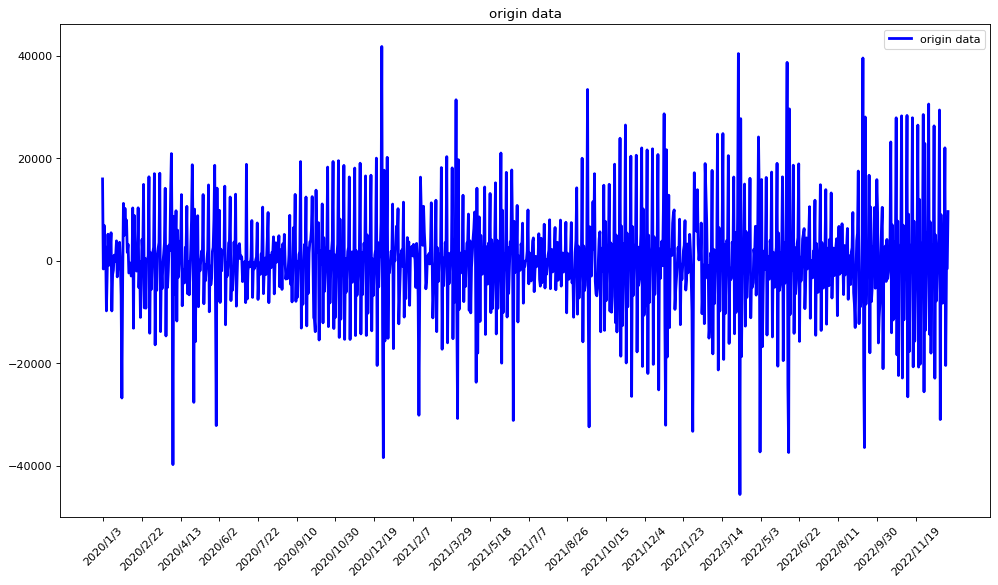

In [12]:
#显示原数据
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date,data, label="origin data", color='b',lw=2.5)  #若不需要日期或者数据没有日期可改成plt.plot(data, label=" ", color='b',lw=2.5)
plt.title("origin data")
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


FileNotFoundError: [Errno 2] No such file or directory: 'result/ACF_PACF.png'

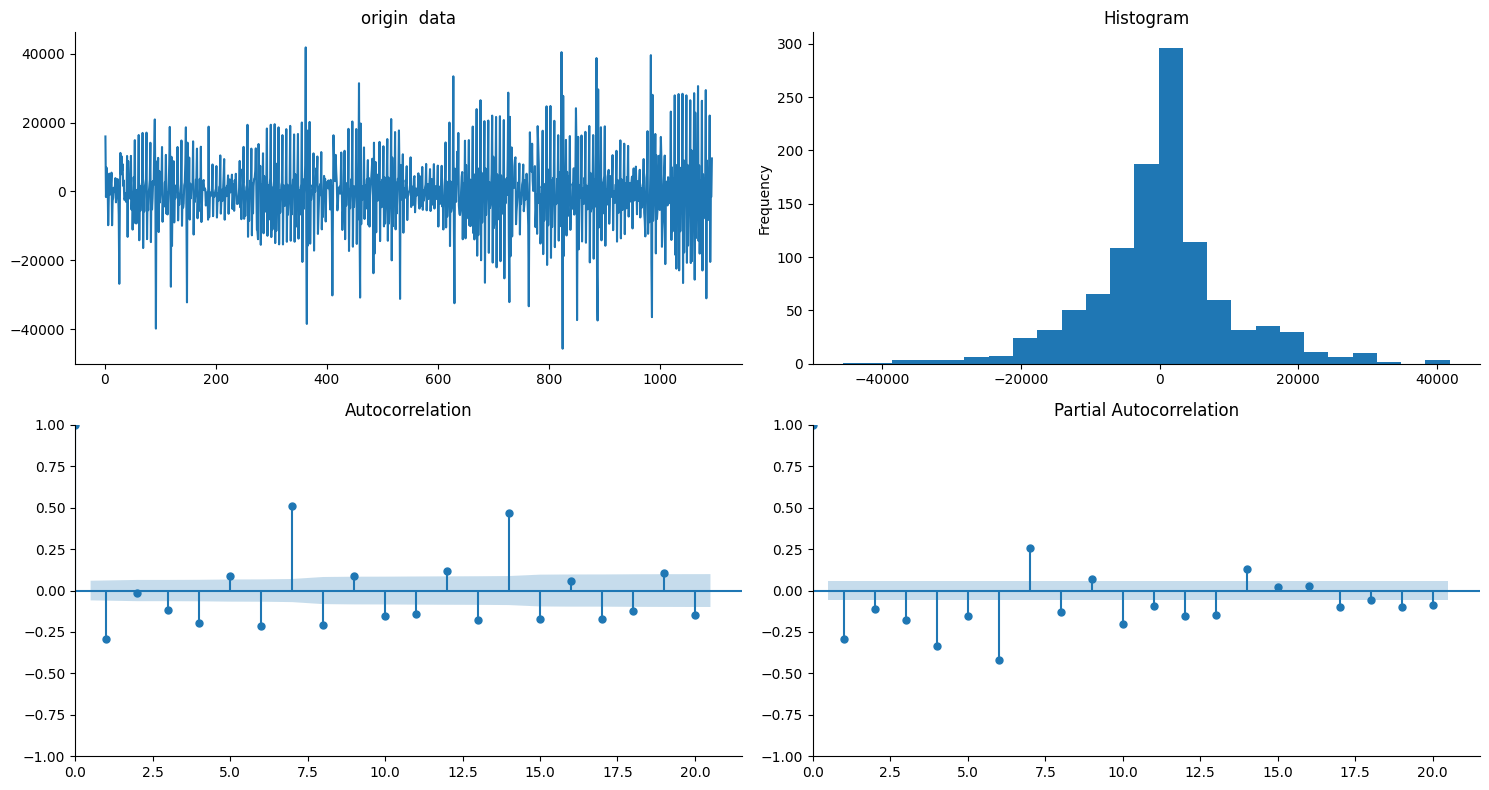

In [13]:
##显示原数据（未差分）的自相关ACF和偏自相关PACF
tsplot(data, lags=20)

In [15]:
t = date[-122:]
t

973       2022/9/1
974       2022/9/2
975       2022/9/3
976       2022/9/4
977       2022/9/5
           ...    
1090    2022/12/27
1091    2022/12/28
1092    2022/12/29
1093    2022/12/30
1094    2022/12/31
Name: date1, Length: 122, dtype: object

In [14]:
del df['date0']
df=df.set_index(['date1'])
df.head()

,sum
date1,
2020/1/1,42889
2020/1/2,58865
2020/1/3,57255
2020/1/4,64181
2020/1/5,64806


Text(0, 0.5, 'Number sum')

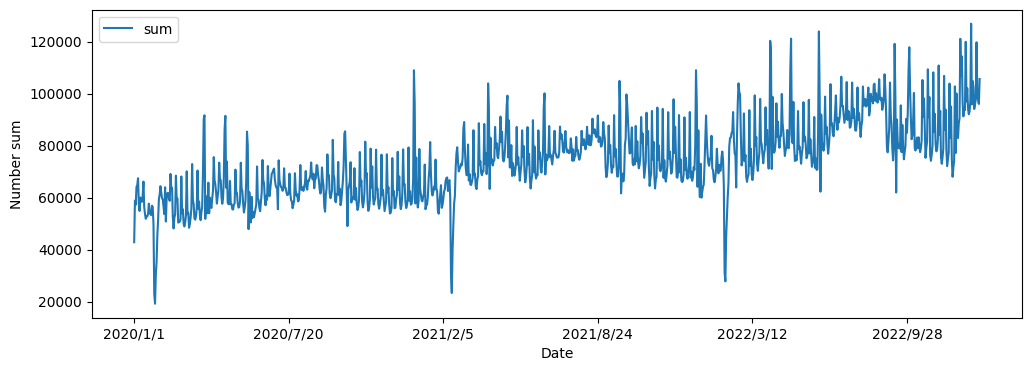

In [15]:
# 可视化时间序列

df.plot(figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('Number sum')

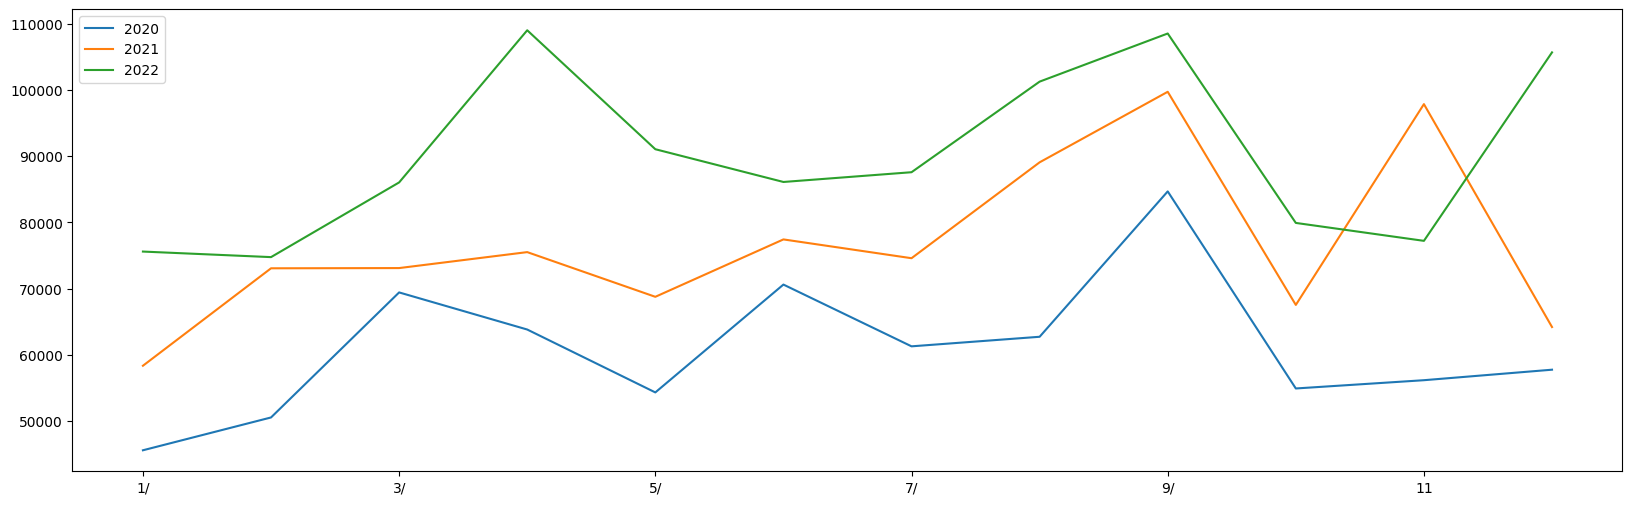

In [16]:
compare={}
for index in df.index:
    year = index[:4]
    month = index[5:7]
    if year not in compare.keys():
        compare.update({year:{month:df['sum'][index]}})
    else:
        compare[year].update({month:df['sum'][index]})
compare = pd.DataFrame(compare)     

compare.plot(figsize=(20,6))
plt.legend(loc=0)

可以看出序列整体走势非常相似

In [17]:
#计算季节指数

ave_k = compare.mean(axis=1)
ave = ave_k.mean()
compare['S'] = ave_k/ave
compare

,2020,2021,2022,S
1/,45618,58373,75601,0.788265
2/,50570,73076,74763,0.870857
3/,69436,73110,86033,1.003279
4/,63838,75518,108990,1.090040
5/,54348,68775,91044,0.940022
6/,70621,77434,86102,1.027762
7/,61302,74598,87573,0.980868
8/,62744,89066,101242,1.110696
9/,84679,99709,108504,1.285562
10,54944,67551,79922,0.888449


如果S比值大于1，说明该季度的值常常会高于总平均值；  

如果比值小于1，说明该季度的值常常低于总平均值；  

如果序列的季节指数都近似为1，就说明该序列没有明显的季节性。  

根据季节指数来看 数据具有一定的季节性，各月份的季节指数存在差异

<AxesSubplot:>

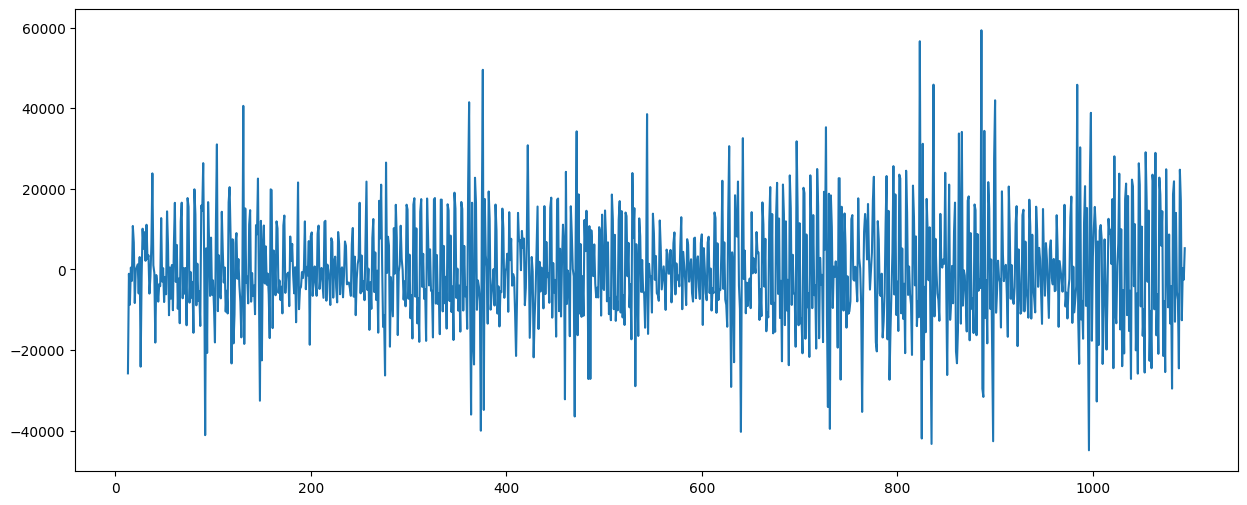

In [18]:
# 季节性差分
dataDiff = data.diff(12)[12:]
dataDiff.plot(figsize=(15,6))

可以看出，季节性基本上被消除

In [19]:
#平稳性检验
adf1, pvalue1, critical_values1 = adf_val(dataDiff, 'raw time series') #对原数据进行平稳性判断
print('adf',adf1)
print('pvalue1',pvalue1)
print('critical_values',critical_values1)
#结果显示，adf结果为-2.2394..， 不小于critical_values的三个level的统计值。pvalue也不接近于0 的，所以是不平稳的，所以需要做一阶差分
#若p值远小于0.01，认为该时间序列是平稳的


[('adf', -8.543791032407736), ('pvalue', 9.624299187693122e-14), ('usedlag', 22), ('nobs', 1059), ('critical_values', {'1%': -3.436540010983293, '5%': -2.8642730819775406, '10%': -2.5682251959417948}), ('icbest', 22329.519734752124)]
adf -8.543791032407736
pvalue1 9.624299187693122e-14
critical_values {'1%': -3.436540010983293, '5%': -2.8642730819775406, '10%': -2.5682251959417948}


In [20]:
#不需要差分

经过了季节性差分和正规差分后，序列成为了平稳时间序列，则我们可以用ARMA模型对多重差分后的模型建模。则我们有模型：

In [21]:
diff1 = dataDiff

In [22]:
from statsmodels.graphics.tsaplots import plot_acf as ACF #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf as PACF   #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox as LjungBox   #白噪声检验
from statsmodels.tsa.arima.model import ARIMA

/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


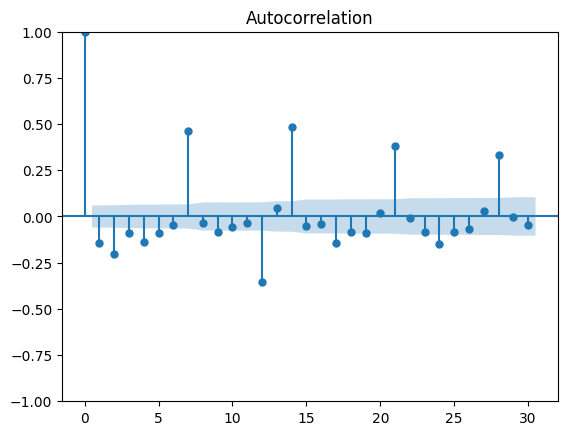

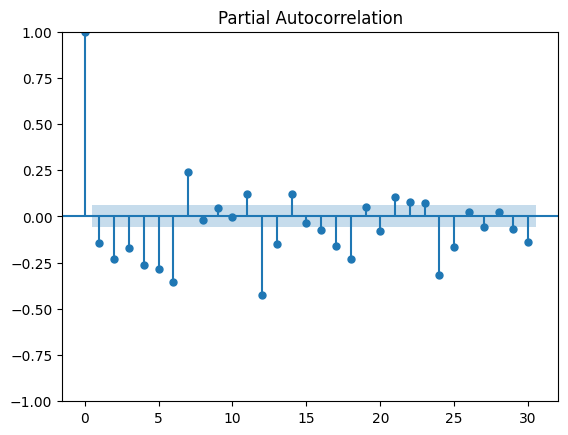

In [23]:
#ACF & PACF plots

lag_acf = ACF(diff1, lags=30)
lag_pacf = PACF(diff1, lags=30)
plt.show()       

In [24]:
import statsmodels.api as sm  # 统计相关的库

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# 创建并拟合 SARIMA 模型
model = SARIMAX(df['sum'][:-122], order=(2, 1, 6), seasonal_order=(2, 1, 6, 12))
results = model.fit()

# 打印模型摘要
print(results.summary())

# 预测未来的数据
forecast_steps = 122
forecast = results.forecast(steps=forecast_steps)


/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05247D+01    |proj g|=  1.37483D-01


 This problem is unconstrained.



At iterate    5    f=  1.04443D+01    |proj g|=  3.58798D-02

At iterate   10    f=  1.04310D+01    |proj g|=  2.22268D-02

At iterate   15    f=  1.04182D+01    |proj g|=  1.27150D-02

At iterate   20    f=  1.04106D+01    |proj g|=  3.10513D-02

At iterate   25    f=  1.04057D+01    |proj g|=  1.12524D-02

At iterate   30    f=  1.04042D+01    |proj g|=  6.54625D-03

At iterate   35    f=  1.04031D+01    |proj g|=  2.15915D-02

At iterate   40    f=  1.03992D+01    |proj g|=  3.23906D-02

At iterate   45    f=  1.03905D+01    |proj g|=  1.85195D-02

At iterate   50    f=  1.03875D+01    |proj g|=  2.64681D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                sum   No. Observations:                  973
Model:             SARIMAX(2, 1, 6)x(2, 1, 6, 12)   Log Likelihood              -10106.993
Date:                            Wed, 03 Jan 2024   AIC                          20247.986
Time:                                    12:18:28   BIC                          20330.724
Sample:                                         0   HQIC                         20279.494
                                            - 973                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7381      0.054    -32.108      0.000      -1.844      -1.632
ar.L2         -0.9256      0.046   

/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


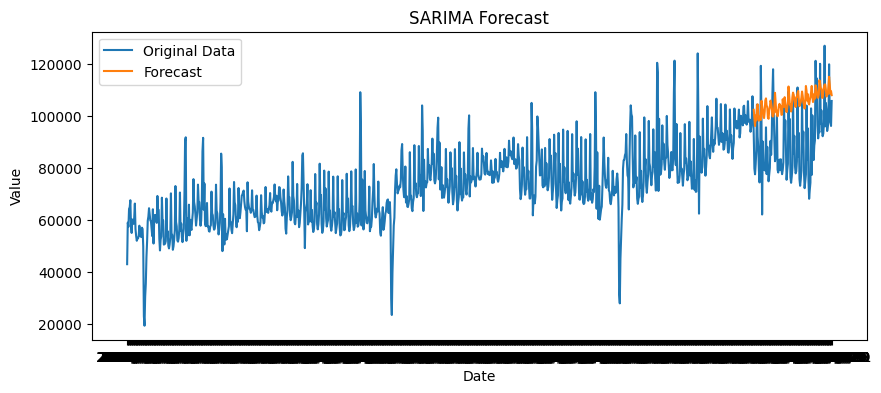

In [27]:
# 可视化原始数据和预测结果
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['sum'], label='Original Data')
plt.plot(forecast.index, forecast, label='Forecast')
# plt.fill_between(forecast.index, forecast.conf_int()['lower data'], forecast.conf_int()['upper data'], color='gray', alpha=0.2)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

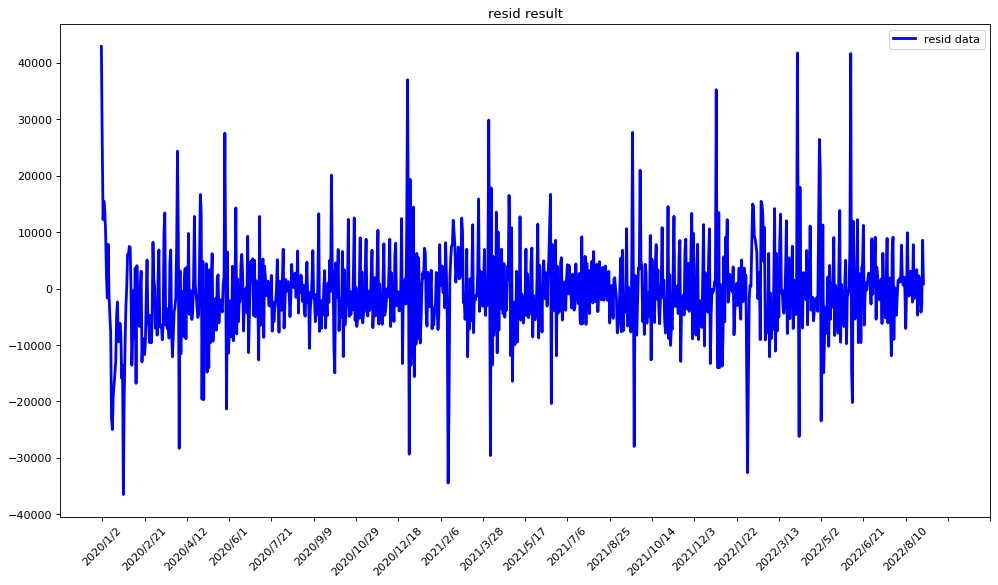

In [28]:
resid=results.resid  #残差
#显示残差校验
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(resid, label="resid data", color='b',lw=2.5)
plt.title("resid result")
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

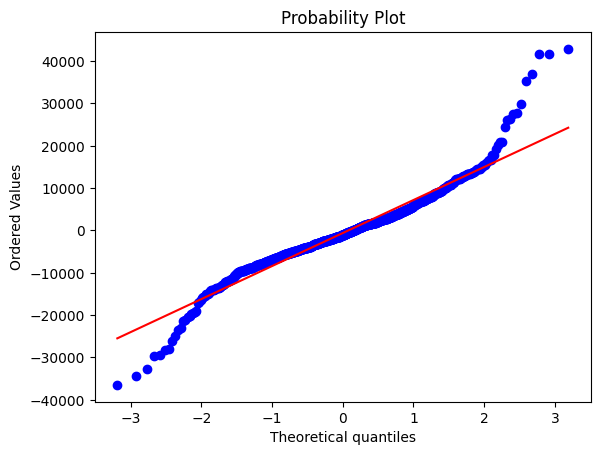

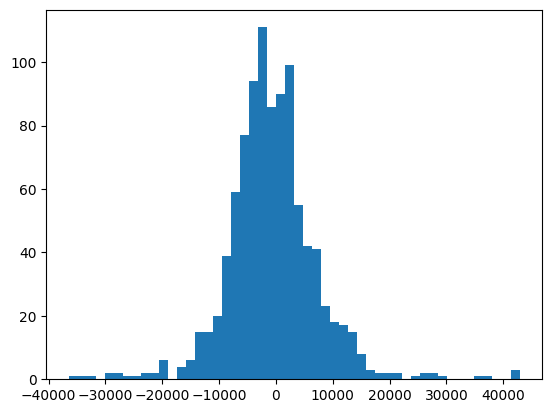

In [29]:
#
stats.normaltest(resid)#检验序列残差是否为正态分布
#qq图散点基本在直线上，同时直方图也呈现正态性
stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=50)
plt.show()

In [30]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [31]:
from keras.models import Sequential

In [32]:
test_ar = df['sum'][-122:]
len(test_ar)

122

In [33]:
pre = forecast
len(pre)

122

In [34]:
#根据arima模型预测的值构建新的数据训练lstm
arima_result = pd.DataFrame(columns=['close'])#生成一个新的DataFrame空数据
arima_result['close'] = test_ar.ravel()#把ARIMA测试数据赋值给新的DataFrame空数据
arima_result['predicted'] = pre.ravel()#把ARIMA预测数据赋值给新的DataFrame空数据
arima_result['residuals'] = arima_result['close'] - arima_result['predicted']#获取这两数据的残缺

#以下是lstm部分
lstm_data=arima_result['residuals'].values#获取残缺项并做数据类型转换
#声明归一化变量
sc = MinMaxScaler(feature_range=(0, 1))
#反归一化
sc_data = sc.fit_transform(lstm_data.reshape(-1,1))

In [35]:
seq_len = 2  #时间步长 t-5,t-4,t-3,t-2,t-1 --->t
#转换成LSTM所需格式，（样本数，步长，特征数）
X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
y_train = np.array([sc_data[i + seq_len, :] for i in range(sc_data.shape[0]- seq_len)])

print(X_train.shape,y_train.shape)

(120, 2, 1) (120, 1)


In [36]:
#lstm网络,keras
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))#lstm层，神经元数为128
# model.add(LSTM(units=128,activation='tanh',return_sequences=False))#lstm层，神经元数为128
model.add(Dropout(0.2))#dropout层
model.add(Dense(1))#全连接层
model.compile(loss='mean_squared_error', optimizer='adam')
#训练
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



2024-01-03 12:19:09.634055: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-01-03 12:19:09.659420: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe129b62140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-03 12:19:09.659434: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/100
 - 0s - loss: 0.1876
Epoch 2/100
 - 0s - loss: 0.1622
Epoch 3/100
 - 0s - loss: 0.1351
Epoch 4/100
 - 0s - loss: 0.1138
Epoch 5/100
 - 0s - loss: 0.0929
Epoch 6/100
 - 0s - loss: 0.0726
Epoch 7/100
 - 0s - loss: 0.0573
Epoch 8/100
 - 0s - loss: 0.0456
Epoch 9/100
 - 0s - loss: 0.0396
Epoch 10/100
 - 0s - loss: 0.0347
Epoch 11/100
 - 0s - loss: 0.0353
Epoch 12/100
 - 0s - loss: 0.0352
Epoch 13/100
 - 0s - loss: 0.0332
Epoch 14/100
 - 0s - loss: 0.0334
Epoch 15/100
 - 0s - loss: 0.0346
Epoch 16/100
 - 0s - loss: 0.0357
Epoch 17/100
 - 0s - loss: 0.0346
Epoch 18/100
 - 0s - loss: 0.0333
Epoch 19/100
 - 0s - loss: 0.0335
Epoch 20/100
 - 0s - loss: 0.0336
Epoch 21/100
 - 0s - loss: 0.0315
Epoch 22/100
 - 0s - loss: 0.0332
Epoch 23/100
 - 0s - loss: 0.0349
Epoch 24/100
 - 0s - loss: 0.0330
Epoch 25/100
 - 0s - loss: 0.0335
Epoch 26/100
 - 0s - loss: 0.0325
Epoch 27/100
 - 0s - loss: 0.0328
Epoch 28/100
 - 0s - loss: 0.0326
Epoch 29/100
 - 0s - loss: 0.0332
Epoch 30/100
 - 0s - lo

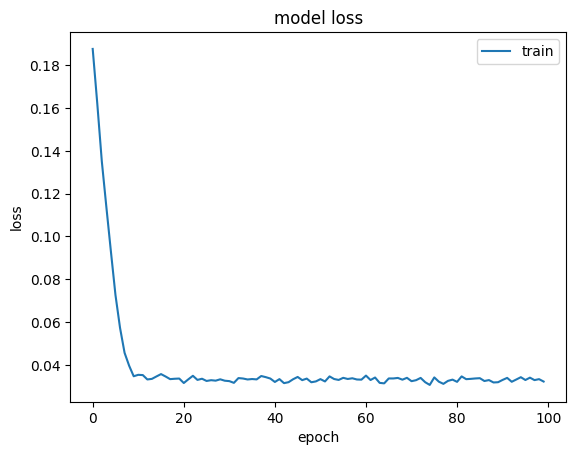

In [37]:
# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [38]:
# 预测训练集数据，预测数据为残缺项数据
lstm_pred = model.predict(X_train)
#对lstm_pred进行反归一化
lstm_pred = sc.inverse_transform(lstm_pred)#反归一化数据为为残缺项数据的预测数据
#对y_train进行反归一化
ytrue = sc.inverse_transform(y_train.reshape(-1,1))#反归一化数据为残缺项数据的真实值


In [39]:
#dtest为最终得到整个arima-lstm模型的预测结果，ytrue为真实值
arima_resid=arima_result['predicted'][-len(lstm_pred):].values.astype(float).reshape(-1,1)
dtest=arima_resid+lstm_pred
ytrue=arima_result['close'][-len(ytrue):].values.reshape(-1,1)+ytrue
#保存Arima-LSTM预测结果到本地
new_result=np.concatenate((dtest,ytrue),axis=1)
dg=pd.DataFrame(new_result,columns=['predict','true'])

In [40]:
#计算评价指标
mse = mean_squared_error(ytrue, dtest)
mae = mean_absolute_error(ytrue, dtest)
rmse = np.sqrt(mse)
r2 = r2_score(ytrue,dtest)

print('mse: %.3f' % mse)
print('mae: %.3f' % mae)
print('rmse: %.3f' % rmse)
print('r2: %.3f' % r2)

mse: 767351197.685
mae: 23935.297
rmse: 27701.105
r2: -0.311


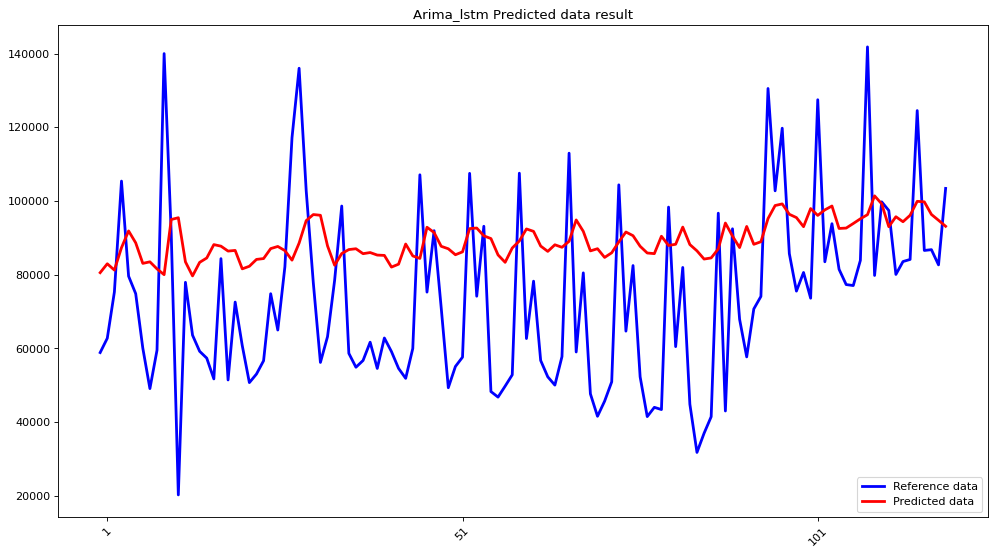

In [41]:
#显示ARIMA-LSTM预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ytrue, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.xticks(range(1,len(pre),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

In [42]:
ndata = df['sum']

In [43]:
len(ndata)-122

973

In [44]:
ndata

date1
2020/1/1       42889
2020/1/2       58865
2020/1/3       57255
2020/1/4       64181
2020/1/5       64806
               ...  
2022/12/27    119754
2022/12/28     99306
2022/12/29     97553
2022/12/30     96051
2022/12/31    105654
Name: sum, Length: 1095, dtype: int64

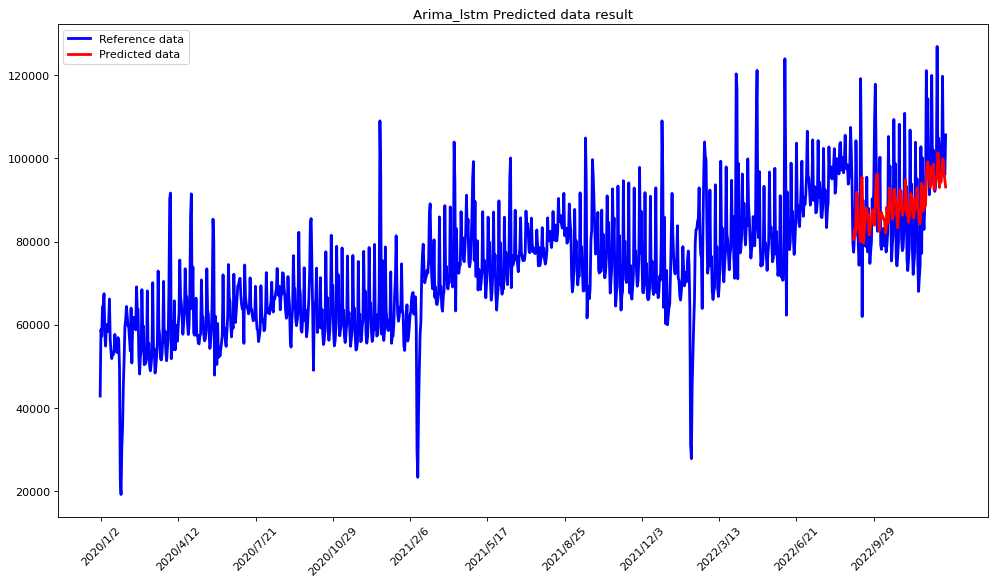

In [45]:
##显示前段数据段加上ARIMA-LSTM预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ndata.index,ndata, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(ndata.index[-120:],dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.xticks(range(1,len(df.index),100),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

In [46]:
# 逆差分操作
reconstructed_data = np.cumsum(np.insert(dtest, 0, dtest[0]))
reconstructed_data

array([   80551.3544812 ,   161102.7089624 ,   244069.50682511,
         325318.03765168,   412650.75998629,   504527.49419623,
         593173.6535867 ,   676246.68160573,   759739.09327997,
         841313.08191823,   921320.30731022,  1016297.95636546,
        1111756.07302925,  1195244.24464379,  1274912.14324074,
        1358258.16162659,  1442793.2174617 ,  1530958.18378182,
        1618702.27359075,  1705112.01053468,  1791698.68806877,
        1873283.46160353,  1955573.98060141,  2039719.57093919,
        2124099.30207068,  2211177.8488689 ,  2298843.63071291,
        2385382.08113516,  2469329.43394062,  2557908.08727277,
        2652585.23355356,  2748909.58401307,  2845036.0042552 ,
        2932855.74494551,  3015414.90310515,  3101155.68008798,
        3187974.47202443,  3275018.6333576 ,  3360721.24556614,
        3446733.81536551,  3532059.58490885,  3617294.8126132 ,
        3699360.03614958,  3782214.1146484 ,  3870539.32397023,
        3955629.72225487,  4040050.55550

In [53]:
# 逆差分操作
reconstructed_data2 = np.cumsum(np.insert(np.array(pre), 0, np.array(pre)[0]))
reconstructed_data2

array([  102268.50091757,   204537.00183514,   303434.61029722,
         399476.68352842,   499500.35053176,   597703.8012802 ,
         700839.67595856,   805215.5820435 ,   906395.60959803,
        1004467.81046862,  1104037.42429131,  1203695.80941393,
        1302036.81800905,  1407771.51589242,  1511522.05931401,
        1613711.01999106,  1713297.22913489,  1812380.77779417,
        1913979.13831678,  2019891.07729315,  2126552.19444583,
        2230184.49388976,  2333644.23197072,  2432969.64027111,
        2531778.53231587,  2633868.73788802,  2737087.59011326,
        2842889.44745836,  2947814.58086486,  3050987.09574025,
        3150816.78350663,  3250486.65851847,  3351313.99229926,
        3455017.64598143,  3563799.80059857,  3668834.183867  ,
        3770045.16233914,  3871971.60826728,  3971730.69024279,
        4073118.09962284,  4176854.362222  ,  4281406.67811512,
        4384986.07070534,  4488608.56208156,  4588933.58249294,
        4689369.86021051,  4795685.56562

In [56]:
data = {'true': df['sum'][-len(reconstructed_data):],
        'sarima-lstm pre': reconstructed_data,
        'arima pre':reconstructed_data2[2:]}
data = pd.DataFrame(data)

In [57]:
data = data.set_index(date[-len(reconstructed_data):]) 

In [58]:
data

,true,sarima-lstm pre,arima pre
date1,,,
2022/9/2,79674,8.055135e+04,3.034346e+05
2022/9/3,77456,1.611027e+05,3.994767e+05
2022/9/4,81387,2.440695e+05,4.995004e+05
2022/9/5,86756,3.253180e+05,5.977038e+05
2022/9/6,104269,4.126508e+05,7.008397e+05
...,...,...,...
2022/12/27,119754,1.041633e+07,1.252141e+07
2022/12/28,99306,1.051610e+07,1.263345e+07
2022/12/29,97553,1.061245e+07,1.274176e+07


In [59]:
data.to_csv('纸味书屋2.csv', index=True)